### Obstacle Benchmark

This benchmark simulates a pyroclastic flow in a channel that includes a an obstacle partway through

In [1]:
import rioxarray as rxr
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.insert(0,"/home/jovyan/shared/Libraries")
import victor
import cartopy.crs as ccrs
import subprocess
import os
import pandas as pd
import xarray as xr
import rasterio as rio
import h5py
from scipy.interpolate import griddata
from rasterio.enums import Resampling
from rasterio.warp import transform_bounds

### To choose between levels of flux, please specify 

In [2]:
easting = 750
northing = 500
dem = "DEMs_PDC_Benchmark/obstacle_arc.asc"
raster = rxr.open_rasterio(dem)
raster = raster.sel({"band": 1})
xll, yll = float(raster.x.min()), float(raster.y.min())
coordinates = np.array([int(easting),int(northing)])
res = raster.rio.resolution()[0]

## Volcflow

### An open source varient running on Octave

In [3]:
os.chdir("Volcflow")
f = open("toposcript_merapi.m","r+")
inp = f.readlines()
inp[0] = f"fid = fopen('../DEMs_PDC_Benchmark/obstacle_arc.grd');\n"
inp[26] = f"dtplot = 1;\n"
inp[27] = f"tmax = 100;\n"
inp[42] = f"V={1e6};\n"
inp[44] = f"r=5;\n"
f.seek(0)
f.writelines(inp)
f.truncate()
f.close()

g = open("output_script.m","r+")
inp = g.readlines()
inp[0] = "fid = fopen('../DEMs_PDC_Benchmark/obstacle_arc.grd');\n"
inp[15] = "out=fopen('obstacle_output.grd','wb');\n"
g.seek(0)
g.writelines(inp)
g.truncate()
g.close()

subprocess.run("octave script_VF_merapi.m",shell=True,stderr=subprocess.DEVNULL)

os.chdir("..")




     ___________  Version n� 4.0.0   ___________
     |                                                 |
     | VolcFlow is a numerical code for the simulation |
     |  of geophysical flows on complex topographies.  |
     |          It is written by Karim Kelfoun,        |
     |      Laboratoire Magmas et Volcans, UMR 6524    |
     |           Clermont-Auvergne University          |
     |      6, avenue Blaise Pascal, 63170 Aubi�re     |
     |           <a href = "http://https://lmv.uca.fr/volcflow/">Visit the VolcFlow web site.</a>          |
     |                                                 |
     |   ---       License : Karim Kelfoun       ---   |
     ���������������������������������������������������
ans = 0
The center of mass is located in i=NaN, j=NaN (in meshes).
Warning ! With a variable time step, dt should be defined so that: dt�2^n = dtplot ! Corrected value: dt = 0.125000 ! 


VolcFlow is now running...
time :    0.000 s., dt =     0.13 s., v max =  m/s (h>

### IMEX_SfloW_2D

In [ ]:
os.chdir("IMEX_SfloW_2D")
f=open("./input_ellipsoid.py","r+")
inp = f.readlines()
inp[0] = f"""DEM_folder = '../DEMs_PDC_Benchmark/'\n"""
inp[1] = f"""DEM_file = 'obstacle_arc.asc'\n"""
inp[2] = f"""x1 = 745\n"""
inp[3] = f"""y1 = 545\n"""
inp[4] = f"""x2 = 755\n"""
inp[5] = f"""y2 = 555\n"""
inp[6] = f"""semi_width = 50 \n"""
inp[7] = f"""vol = 1e6\n"""
f.seek(0)
f.writelines(inp)
f.truncate()
f.close()
!python create_input_ellipsoid.py

f=open("./IMEX_SfloW2D.inp","r+")
inp = f.readlines()
inp[1] =  'RUN_NAME="obstacle_arc",\n'
inp[2] =  f"""RESTART=T,\n"""
inp[3] =  f"""T_START=  0     ,\n"""
inp[4] =  f"""T_END=  100,\n"""
inp[5] =  f"""DT_OUTPUT=  10,\n"""
inp[13] = f"""X0={xll},\n"""
inp[14] = f""" Y0=  {yll}     ,\n"""
inp[16] = f""" COMP_CELLS_X=  300,\n"""
inp[17] = f""" COMP_CELLS_Y=  1000,	\n"""
inp[18] = f""" CELL_SIZE = 5.0D0    ,\n"""
f.seek(0)
f.writelines(inp)
f.truncate()
f.close()

p = subprocess.Popen(['./IMEX_SfloW2D'], stdin=subprocess.PIPE, shell=True, stdout=subprocess.DEVNULL)
os.chdir("..")

### TITAN2D

In [ ]:
os.chdir("Titan2D")

f=open("./input.py","r+")
inp = f.readlines()
inp[4] = "    gis_map='../DEMs_PDC_Benchmark/obstacle_arc.asc',\n"
inp[23] = "     influx=10.0,\n"
inp[24] = "    start_time=0.0,\n"
inp[25] = "   end_time=100.0,\n"
inp[26] = "    center=[500.0, 750.0],\n"
f.seek(0)
f.writelines(inp)
f.truncate()
f.close()

subprocess.run("./titan -nt 4 input.py",shell=True,stdout=subprocess.DEVNULL)

In [ ]:
height = []
os.chdir("vizout")
result = subprocess.run("ls -1 | sort | tail -n 1", capture_output=True, text=True,shell=True)
filename = result.stdout.strip()
with h5py.File(filename, 'r')  as h5f: # file will be closed when we exit from WITH scope
    connections = h5f.get("Mesh/Connections")
    points = h5f.get("Mesh/Points")
    height = h5f.get("Properties/PILE_HEIGHT")[:]
    centers = []
    for i in range(connections.shape[0]):
        midpoint = points[np.sort(connections[i,:])]
        out = np.mean(midpoint,axis=0)
        centers = np.append(centers,out,axis=0)
    centers = np.reshape(centers,(connections.shape[0],3))
height = np.ndarray.flatten(height)
df = {"X_CENTER": centers[:,0], 'Y_CENTER': centers[:,1], 'Z_CENTER': centers[:,2],'PILE_HEIGHT': height}
df = pd.DataFrame(df)
nonzero = df["PILE_HEIGHT"] > 0
flow = df[nonzero]
os.chdir("../..")
flow.to_csv("./titandata.csv")

In [9]:
vals = pd.read_csv("titandata.csv",skiprows=3, names=["x","y","z","thickness"])
points = list(zip(vals.x,vals.y))
values = vals.thickness.values
xRange = np.arange(vals.x.min(),vals.x.max()+res,res)
yRange = np.arange(vals.y.min(),vals.y.max()+res,res)
gridX,gridY = np.meshgrid(xRange, yRange)
gridPh = griddata(points, values, (gridX,gridY), method='linear')
gridPh = np.nan_to_num(gridPh, nan=-999999)
rasterCrs = rio.crs.CRS.from_epsg(4326)
transform = rio.transform.Affine.translation(gridX[0][0]-res/2, gridY[0][0]-res/2)*rio.transform.Affine.scale(res,res)
interpRaster = rio.open('Titan2D/titan_obstacle.asc',
                                'w',
                                driver='AAIGrid',
                                height=gridPh.shape[0],
                                width=gridPh.shape[1],
                                count=1,
                                dtype=gridPh.dtype,
                                crs=rasterCrs,
                                transform=transform,
                                nodata=-999999
                                )
interpRaster.write(gridPh,1)
interpRaster.close()

Text(0.5, 1.0, 'IMEX_SfloW2D')

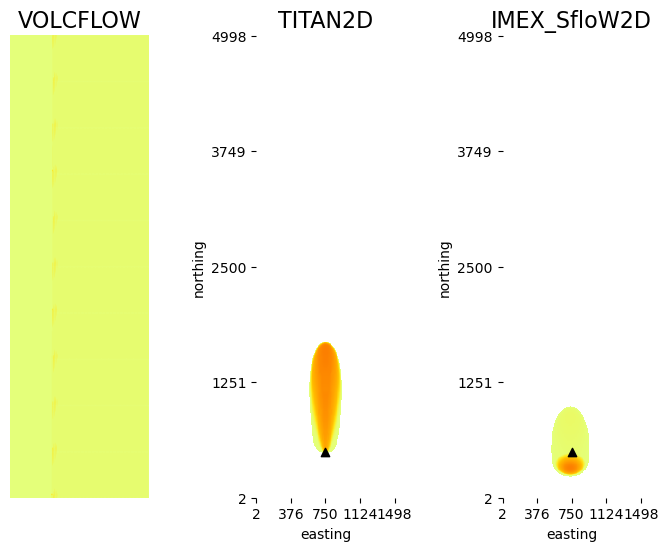

In [4]:
fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, nrows=1,subplot_kw=dict(projection=ccrs.epsg(32628)), figsize = (9,6))

thickness0,maxval0 = victor.plot_benchmark(dem, "./VolcFlow/obstacle_output.grd", fig, ax0, coordinates, zoom=False)
ax0.set_title('VolcFlow', fontsize=16)

thickness1,maxval1 = victor.plot_benchmark(dem, "./Titan2D/titan_obstacle.asc", fig, ax1, coordinates, zoom=False)
ax1.set_title('TITAN2D', fontsize=16)

thickness2,maxval2 = victor.plot_benchmark(dem, "./IMEX_SfloW_2D/obstacle_arc_0010.asc", fig, ax2, coordinates, zoom=False)
ax2.set_title('IMEX_SfloW2D', fontsize=16)